In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import shap



In [8]:
df = pd.read_csv('../../DSML34/customer-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


C:\Users\ajink\AppData\Local\Temp\ipykernel_6548\3633085496.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


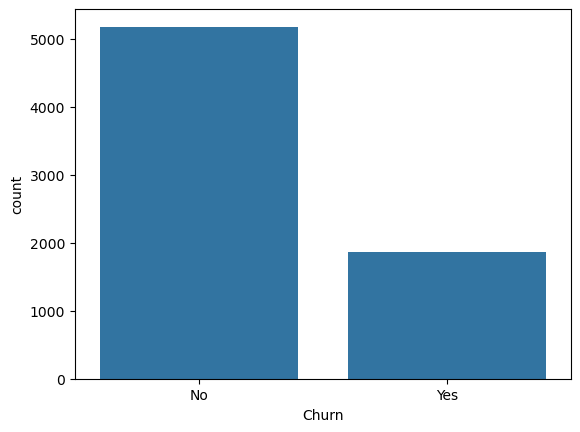

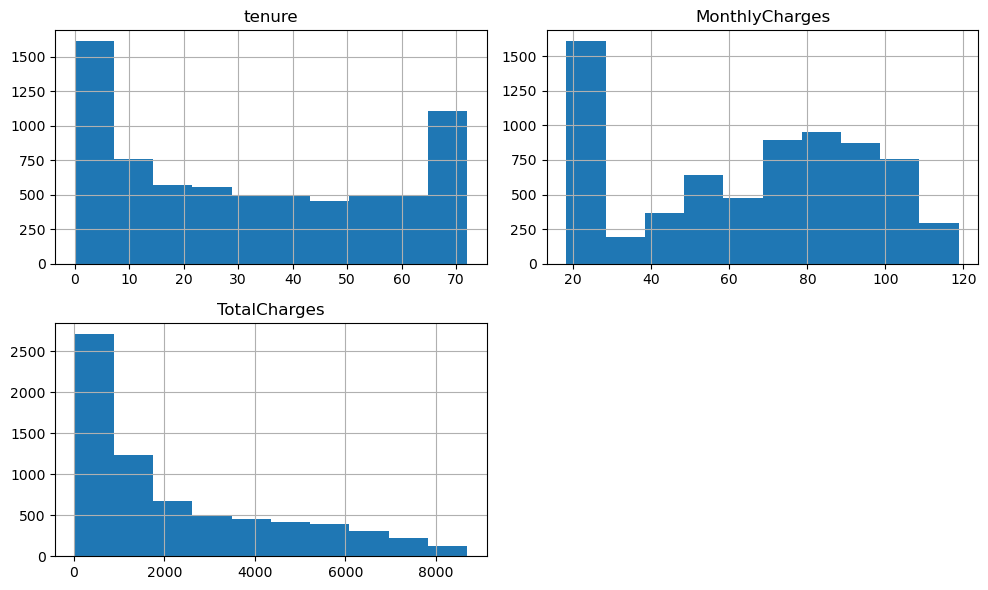

In [10]:
df.info()
df.describe()
df.isnull().sum()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

sns.countplot(x='Churn', data=df)

num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_cols].hist(figsize=(10,6))
plt.tight_layout()


In [12]:
df.drop('customerID', axis=1, inplace=True)

cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    if df[col].nunique() == 2:
        df[col] = LabelEncoder().fit_transform(df[col])
    else:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


In [14]:
df['tenure_group'] = pd.cut(df['tenure'], bins=[0,12,24,48,60,72], labels=['0-12','12-24','24-48','48-60','60-72'])
df = pd.get_dummies(df, columns=['tenure_group'], drop_first=True)


In [16]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [18]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.49      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



In [20]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))


C:\Users\ajink\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:05:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Results:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1035
           1       0.60      0.53      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409



In [22]:
model = Sequential([
    Dense(32, input_dim=X_train.shape[1], activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

y_pred_dl = (model.predict(X_test) > 0.5).astype('int32')
print("DL Model Results:")
print(classification_report(y_test, y_pred_dl))


Epoch 1/20


C:\Users\ajink\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7542 - loss: 0.4960
Epoch 2/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8075 - loss: 0.4160
Epoch 3/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8001 - loss: 0.4203
Epoch 4/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8079 - loss: 0.4111
Epoch 5/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7979 - loss: 0.4266
Epoch 6/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8170 - loss: 0.4012
Epoch 7/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8039 - loss: 0.4130
Epoch 8/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8160 - loss: 0.3979
Epoch 9/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8110 - loss: 0.4076
Epoch 10/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8058 - loss: 0.4146
Epoch 11/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8084 - loss: 0.4083
Epoch 12/20
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy

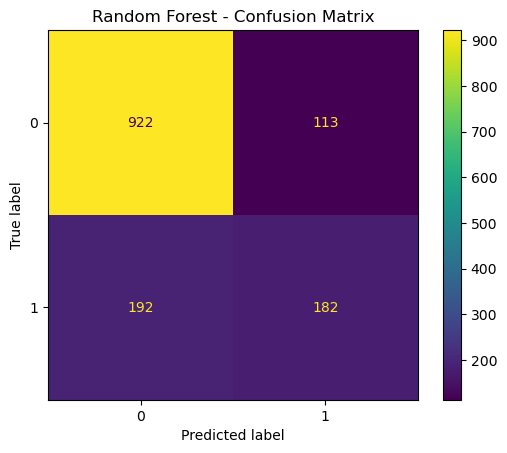

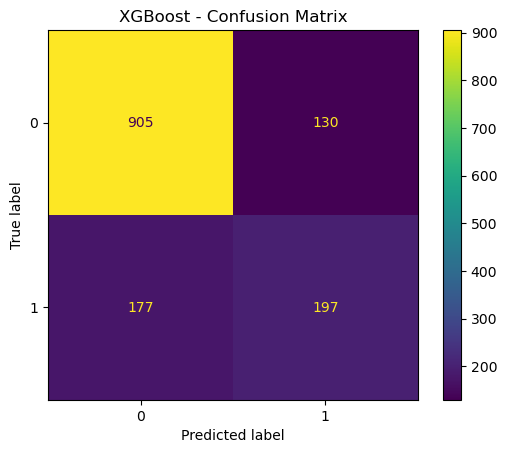

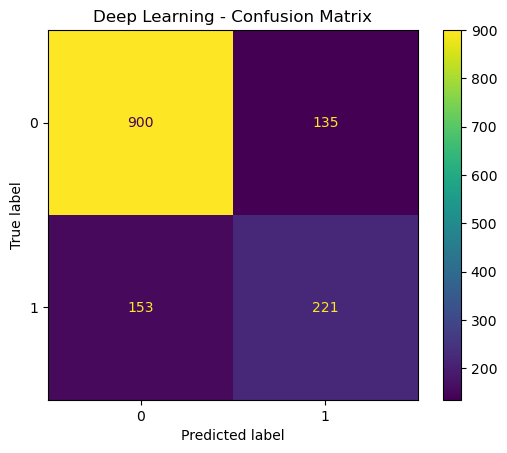

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


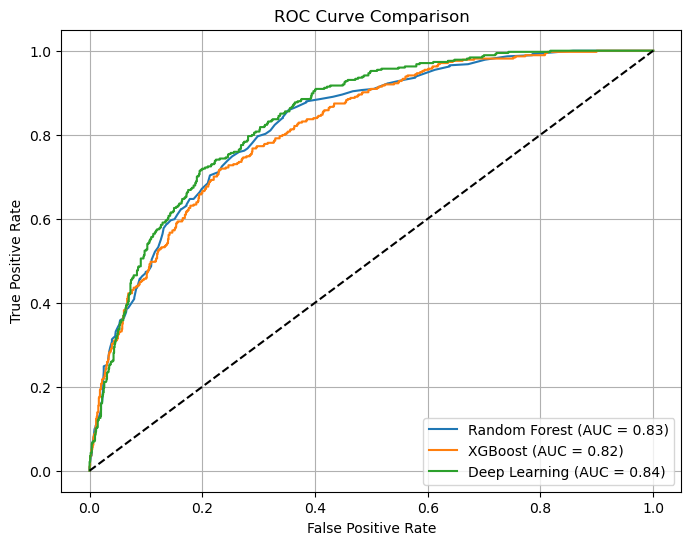

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score, roc_curve

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title("Random Forest - Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb)
plt.title("XGBoost - Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dl)
plt.title("Deep Learning - Confusion Matrix")
plt.show()

y_pred_rf_prob = rf.predict_proba(X_test)[:, 1]
y_pred_xgb_prob = xgb.predict_proba(X_test)[:, 1]
y_pred_dl_prob = model.predict(X_test).ravel()

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb_prob)
fpr_dl, tpr_dl, _ = roc_curve(y_test, y_pred_dl_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_rf_prob):.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, y_pred_xgb_prob):.2f})')
plt.plot(fpr_dl, tpr_dl, label=f'Deep Learning (AUC = {roc_auc_score(y_test, y_pred_dl_prob):.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


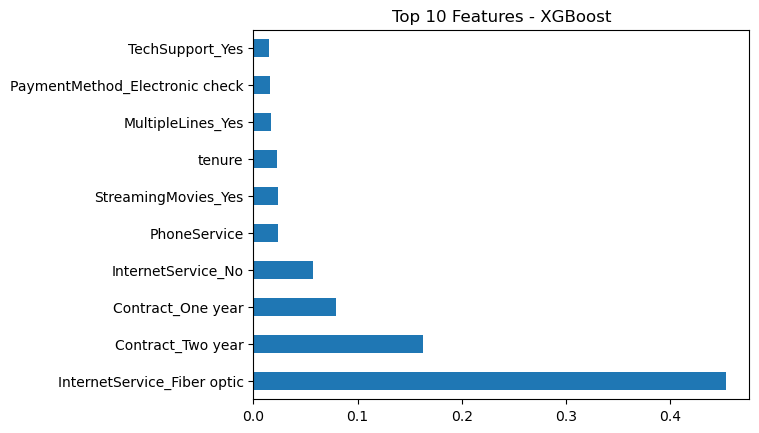

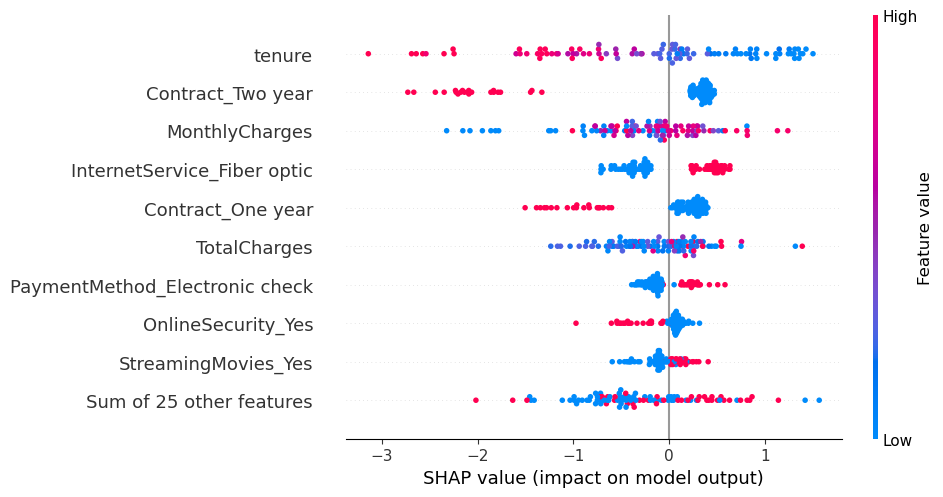

In [26]:
xgb_feat_imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)[:10]
xgb_feat_imp.plot(kind='barh')
plt.title("Top 10 Features - XGBoost")
plt.show()

explainer = shap.Explainer(xgb)
shap_values = explainer(X_test[:100])
shap.plots.beeswarm(shap_values)


In [ ]:
Bonus :
Target short tenure customers with offers.

Promote long-term contracts.

Upsell online security and tech support.

Reduce monthly charges for high spenders.

Improve fiber optic service experience.

Implement predictive churn monitoring and personalized retention.